# CSS Labs: Algorithms & Society with Chicago Potholes
In this lab, we'll explore the effects of algorithms on society by using data from [Chicago's Open Data portal](https://data.cityofchicago.org). 

#### Imagine we work for the Chicago Department of Transportation (CDoT)
We will build an algorithm to solve a problem the City faces every day, and then see what concequences that algoirthm might have in the real world. For the rest of this lab, we will pretend that we are CDoT employees. 

## Section 1: Background
### 1.1 Learning Objectives
1. Become familiar with Chicago open city data.
1. Understand how algorithms can be used to inform policy and real-world decisions.
1. Understand how algorithms can sometimes have adverse, unintended concequences when used for decisionmaking. 

### 1.2 Data
- Data for this lab come from [Chicago's Open Data portal](https://data.cityofchicago.org). They're all real data.
- For simplicity, we merged multiple data sets before this lab that have information about the city's population (size, age, health, race, class, education, income), infrasctructure (housing, streets, traffic), and services (311, repairs, complaints about police). 

## Section 2: Setup
### 2.1 Import Python Modules
Run the following cell to import the necessary python modules.

In [1]:
import pandas as pd
import datetime
from tqdm import tqdm 
from scipy.stats import linregress, nbinom
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

%matplotlib inline

### 2.2 Data
Run the following cell to import the data.

In [2]:
calls = pd.read_csv('data/clean/311_complaints_by_community_area.tsv', sep='\t')
stats = pd.read_csv('data/clean/community_area_stats.tsv', sep='\t')
ph_reports = pd.read_csv('data/clean/potholes.tsv.gz', sep='\t')

#data preparation
ph_reports['creation_date'] = pd.to_datetime(ph_reports.creation_date, format="%m/%d/%Y")
ph_reports['completion_date'] = pd.to_datetime(ph_reports.completion_date, format="%m/%d/%Y")
ph_reports['days_open'] = (ph_reports.completion_date - ph_reports.creation_date).apply(lambda x: x.days)
ph_reports.sort_values(by='creation_date', inplace=True)

#### About pothole data
- Part of CDoT's job is to fill potholes in city streets. To do this, they rely on city residents reporting potholes to the 311 system, which keeps track of all the reported pothole locations as well as the status of repairs.
- The pothole data lists every report of a pothole to the city between January 1, 2011, and December 31, 2018.
- Below, we take a peak at the data to get a feel for what it looks like. 
- Notice that the number of pothole reports the city gets changes over time. This is true for two major reasons:
    - Winter weather damages streets. When the streets thaw out each spring, that damage turns into potholes. Therefore, we see more reports in the spring than other times of year.
    - Some winters are more mild or harsh than other winters. 2014 was one of the [worst winters on record](https://en.wikipedia.org/wiki/Early_2014_North_American_cold_wave), and we see many more pothole reports that year.
- Notice also that we have the average amount of traffic on the streets with reported potholes. 
    - This comes from a different city data source, which measures the number of cars per day driving on busy streets.
    - About half of pothole reports are from streets with no traffic data. These streets are generally small and have low traffic.

In [3]:
ph_reports.tail()

,creation_date,completion_date,request_number,outcome,n_potholes_on_block,address,community_area_number,ssa,avg_traffic,days_open
551740,2018-12-15,2018-12-17,18-03364263,NaN,NaN,700 W GRAND AVE,24,NaN,17706.0,2
552175,2018-12-15,2018-12-31,18-03365265,pothole,17.0,8200 S SPRINGFIELD AVE,70,NaN,NaN,16
551873,2018-12-17,2018-12-18,18-03378491,pothole,0.0,700 N DRAKE AVE,23,63.0,NaN,1
551872,2018-12-17,2018-12-18,18-03378095,pothole,7.0,600 W LAKE ST,28,NaN,10550.0,1
552174,2018-12-17,2018-12-31,18-03378790,NaN,NaN,400 S FINANCIAL PL,32,NaN,2800.0,14


Text(0.5, 1.0, 'Pothole reports per week')

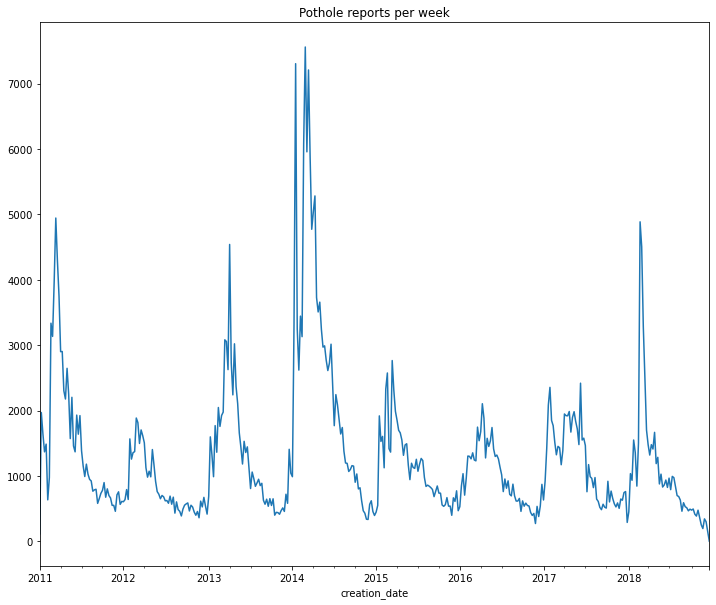

In [4]:
ph_reports.resample('w', on='creation_date').request_number.count().plot(figsize=(12,10))
plt.title('Pothole reports per week')

#### Short answer 1:
- The city recieves thousands of pothole reports every week! While they do eventually fix all potholes, with so many reports it can be hard for us to know where to start. 
- What are the ways you can think of to fix the potholes? How do you know which potholes to fix first? What do your determine the order of fixing? Please describe **one** approach that you think of and explain your **reasoning** behind it.

#### 🤔 Write your answers here:
- .
- .

## Section 3: Algorithm to the Rescue

- Algorithms, "expert systems," and machine learning can give us a prioritized list of where to work first. 
    - In real life, Chicago already uses one of these to plan their pothole repair schedule. 

#### Approaches
- As with any problem, there are multiple ways we can try to solve this and get the city a list of which potholes to repair first. 
    - **Random**: We could just pick random potholes to fix each day. This gives every pothole an equal chance of being fixed each day.
    - **First come, first serve**: We could fix the potholes in the order they get reported to us.
    - **Busy streets first**: We could fix potholes on the busiest streets first, so that the repairs we make help the largest number of drivers.
    - **Most complaints first**: Multiple people can (and do) call to complain about a single pothole. In order to minimize complaints, we could fix the potholes with the most complaints first. 
    - **Other**: We could think of other ways as well. The real algorithm the city uses is more complicated than these ones.

#### Short answer 2:
- Which of these do you think we should use? In a few sentences, say why.
- Which of these do you think is the worst idea? In a few sentences, say why. 

#### 🤔 Write your answers here:
- .
- .

#### Helper functions
- Don't worry how exactly the code in the cell works. Just run it and scroll down.

In [5]:
rules = ['random', 
         'real', 'high_traffic_first', 'first_come_first_serve', 
         'high_complaint_first']

# duplicate reports are closed on the same day for the same address
g = ph_reports.groupby(['completion_date', 'address'])

# the number of potholes found when the city went to repair
a = g[['n_potholes_on_block']].mean()

# a way to count the number of rows / reports for each pothole group
b = g[['community_area_number']].count()
b.columns = ['n_reports']

# put together the data above and rename the columns
c = a.merge(b, left_index=True, right_index=True).reset_index().reset_index()
c.columns = ['pothole_id', 'completion_date', 'address', 'n_potholes_on_block',
             'n_reports']

# merge our findings back into the reports data
ph_reports = ph_reports.merge(c).sort_values(by='creation_date')

# remove the duplicate reports
potholes = ph_reports.drop_duplicates(subset=['pothole_id'], keep='first')

# remove reports that are not on city property
potholes = potholes[potholes.outcome != 'bad_request']

def run_simulation(rule='random', per_day='real'):
    start = datetime.datetime(year=2011, month=1, day=1)
    end = datetime.datetime(year=2019, month=1, day=1)

    #the number of blocks fixed per day
    if per_day == 'mean':
        spd = int(potholes.groupby('completion_date').request_number.count().mean())
    if per_day == 'median':
        spd = int(potholes.groupby('completion_date').request_number.count().median())
    elif per_day == 'real':
        spd = potholes.groupby('completion_date')[['request_number']].count().reset_index().sort_values(by='completion_date')

    reports = ph_reports[['creation_date', 'pothole_id', 'n_reports']]
    result = potholes.copy()
    result = result[['creation_date', 'completion_date', 'n_potholes_on_block', 'community_area_number', 'ssa',
           'avg_traffic', 'days_open', 'pothole_id']]
    result = result[(result['creation_date'] <= end) & (result['creation_date'] >= start)]
    
    #if using the real results, skip the simulation
    if rule != 'real':
        result['completion_date'] = pd.NaT

        # walk through time one day at a time
        for today in tqdm(spd.completion_date):
            #get all complaints up to today
            complaints = reports[reports.creation_date <= today]
            #count complaints per pothole
            complaints = complaints.groupby('pothole_id').n_reports.count().reset_index()

            #get all potholes that aren't yet resolved
            unresolved = result[result.completion_date.isna()]
            unresolved = unresolved.merge(complaints, how='inner', on='pothole_id')

            #figure out how many potholes we can fix today
            if per_day == 'real':
                n_done = spd[spd.completion_date == today].request_number.values[0]
            else:
                n_done = spd
            
            #decide what to fix based on our rule
            if rule == 'random':
                fix = unresolved.pothole_id.sample(n=min(n_done, unresolved.shape[0]))
            elif rule == 'first_come_first_serve':
                fix = unresolved.sort_values(by='creation_date').pothole_id.head(n=n_done)
            elif rule == 'high_traffic_first':
                fix = unresolved.sort_values(by=['avg_traffic', 'creation_date'], 
                                             ascending=[False, True]).pothole_id.head(n=n_done)
            elif rule == 'high_complaint_first':
                fix = unresolved.sort_values(by=['n_reports', 'creation_date'], 
                                             ascending=[False, True]).pothole_id.head(n=n_done)
            else:
                print('Invalid rule. Check your spelling?')
                return
            
            # fix the selected potholes today
            result.loc[result.pothole_id.isin(fix), 'completion_date'] = today
            
        result['days_open'] = (result.completion_date - result.creation_date).apply(lambda x: x.days)
    
    return result

### Simulation
- In this next cell, we're going to simulate what would have happened if the city used each of our algorithms. The simulation doesn't look like much while it is running; we just see a progress bar. In the simulation code, however, your computer is doing a lot. 
- Simulation steps:
    1. Begin January 1st, 2011.
    2. Get the list of complaints to the city about potholes made on that day.
    3. See how many potholes the city was able to fix that day (this changes each day depending on many things, like weekends or bad weather). Call this number N.
    4. Use the algorithm to rank which potholes are highest priority.
    5. Fix the top N potholes with the highest priority.
    6. Leave the remaining potholes to be fixed in the future.
    7. Fast-forward to the next day.
    8. Repeat steps 2-7 until December 31, 2018.
- **Note**: the simulation is a little slow. It may take ~10 minutes to test all algorithms.

In [6]:
results = dict()

for r in rules:
    print(r)
    results[r] = run_simulation(rule=r)

random


100%|██████████| 2096/2096 [05:36<00:00,  6.22it/s]


real
high_traffic_first


100%|██████████| 2096/2096 [05:42<00:00,  6.12it/s]


first_come_first_serve


100%|██████████| 2096/2096 [05:41<00:00,  6.14it/s]


high_complaint_first


100%|██████████| 2096/2096 [05:30<00:00,  6.34it/s]


#### How long does each algorithm take to fix potholes?

#### Below, we can see histograms of the data. Note that the scale of x- and y-axes are different.

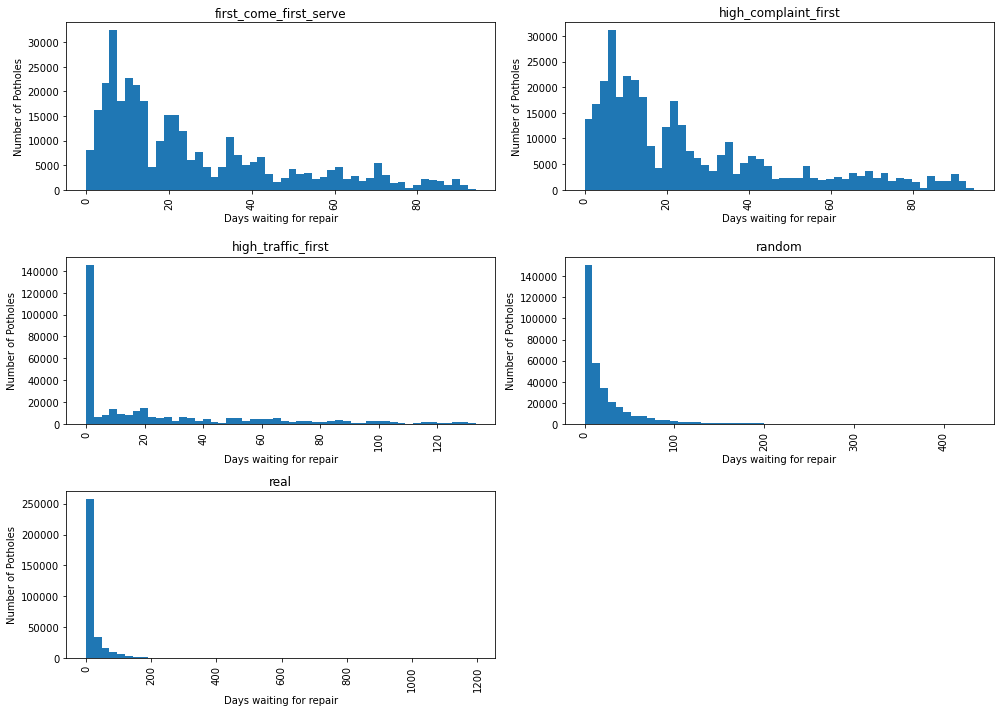

In [8]:
long = []
for r in results.keys():
    tmp = results[r][['pothole_id', 'days_open']].copy()
    tmp['simulation'] = r
    long.append(tmp)
long = pd.concat(long)

ax = long[['simulation', 'days_open']].hist(by='simulation', bins=50, figsize=[14,10])
for a1 in ax:
    for a in a1:
        a.set_xlabel("Days waiting for repair")
        a.set_ylabel("Number of Potholes")
plt.tight_layout()
plt.show()

- Below, we see some summary statistics for how long it took to fix potholes with each algorithm.
- Look at the row for the real algorithm. It shows a few things:
    - The minimum number of days to fix a pothole is 0: some were fixed on the same day they were reported!
    - 25% of potholes were fixed within 1 day, 50% were fixed within 6 days, and 75% were done within 22 days of the initial complaint. 
    - But the maximum number of days is 1194: that's over 3 years waiting! 
- Compare this to the first come first serve algorithm.
    - The maximum wait time is only 94 days, but 50% potholes take more than 18 days.

In [9]:
long = []
for r in results.keys():
    tmp = results[r][['pothole_id', 'days_open']].copy()
    tmp['simulation'] = r
    long.append(tmp)
long = pd.concat(long)

long.groupby(by='simulation').days_open.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
simulation,,,,,,,,
first_come_first_serve,340041.0,25.3,22.2,0.0,8.0,18.0,36.0,94.0
high_complaint_first,340041.0,25.3,23.1,0.0,8.0,17.0,36.0,95.0
high_traffic_first,340041.0,25.3,33.6,0.0,0.0,9.0,41.0,133.0
random,340041.0,25.3,37.6,0.0,3.0,11.0,31.0,434.0
real,340041.0,25.3,55.7,0.0,1.0,6.0,22.0,1194.0


#### Short answer 3:
- This table contains lots of information such as the minimum, maximum, and median wait time. What statistics presented in the table do you think is important to consider? Based on the statistics, which algorithm do you think the city should use, and why? Explain your reasoning in a few sentences.

#### 🤔 Write your answers here:
- .
- .

## Section 4: Unintended Concequences
- We saw in the previous section that some potholes get fixed faster than others in each algorithm. The algorithms decided what order to fix potholes in based on seemingly neutral things, like what order they were reported or how busy the streets are.
- One of the big challenges in algorithm design, however, is that algorithms with seemingly neutral inputs can sometimes still result in unfair or biaded outcomes.
- In this section, we will look at whether our algorithms treat different Chicago neighborhoods fairly.

#### Helper functions
Don't worry about how this code works, just run it and scroll down.

In [ ]:
subset = ['pct_white', 'per_capita_income_', 'community_area_number',
          'pct_rental_housing', 'total_population', 'median_age',
          'percent_households_below_poverty', 'police_complaints_per_thousand']

together = potholes[['creation_date', 'pothole_id', 'community_area_number', 'avg_traffic']]
for r in results.keys():
    tmp = results[r][['pothole_id', 'days_open']]
    tmp.columns = ['pothole_id', r]
    together = together.merge(tmp, on=['pothole_id'])
together = together.merge(stats[subset], on='community_area_number', how='left')

long2 = []
for r in results.keys():
    tmp = results[r][['pothole_id', 'days_open', 'community_area_number']].copy()
    tmp['simulation'] = r
    long2.append(tmp)
long2 = pd.concat(long2)
long2 = long2.groupby(by=['simulation', 'community_area_number']).median().reset_index()

#### Does everyone wait the same amount of time for repairs?
- In the histgram below, we look at how long each community area (neighborhood) has to wait for potholes to be fixed. 

In [ ]:
ax = long2[['simulation', 'days_open']].hist(by='simulation', bins =[0,1, 2, 3, 4, 5, 6,7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21,22,23, 24,25, 26, 27,28, 29, 30], figsize=(14,10), sharey=True,sharex=True)
for a1 in ax:
    for a in a1:
        a.set_xlabel("Average (median) days waiting for repair")
        a.set_ylabel("Number of Community Areas")
plt.tight_layout()
plt.show()

#### Short answer 4:
One way to measure fairness is to see if every community has to wait about the same amount of time for repairs.
- Based on the plot, which algorithm do you think is most fair? Why?
- Which algorithm seems to be the least fair? Why? 

#### 🤔 Write your answers here:
- .
- .

#### Which communities are getting slower service?
- Now that we know not all communities have to wait equally for repairs when using our algorithms, let's look at which ones get faster and slower service. 
- In the example below, we'll look at neighborhood income to see if high and low income neighborhoods are treated the same by each algorithm. 

In [ ]:
outcome = 'per_capita_income_'

In [ ]:
tmp = together[together[outcome].notna()].copy()
tmp = tmp.groupby(outcome).median().reset_index().sort_values(by=outcome)

fig, ax = plt.subplots(figsize=(15,15))
for r in rules:
    plt.scatter(x=tmp[outcome], y=tmp[r].values, alpha=.7)
    y2 = lowess(endog=tmp[r], exog=tmp[outcome], is_sorted=True)[:,1]
    plt.plot(tmp[outcome], y2, label=r, linewidth=4)

ax.set_xlabel('Community area '+outcome)
ax.set_ylabel('Median number of days')
ax.set_title('Average time to fix potholes')
plt.legend()
plt.show()

Below we show two maps of Chicago. 
On the left, neighborhoods are colored by their per capita income. A darker red indicates higher per capita income, and a lighter yelloe indicates lower per capita income. 
On the left, neighborhoods are colored by the number of potholes in them. A darker red indicates more potholes, and a lighter yelloe indicates fewer potholes. 
Comparing the two maps, what do you find? Can you use the two maps to explain the bump in the curve of the high traffic first algorithm?

![potholes-income.png](potholes-income.png)

#### Short answer 5:

- Which algorithms result in **equal** treatment across neighborhoods with different income? How do you know? 
- Which algorithms result in **different** treatment across neighborhoods with different income? How do you know? 

#### 🤔 Write your answers here:
- .
- .

#### Extreme wait times
- Often in government, business, and other areas, we have specific goals we want to meet. For example, maybe we want to fix potholes within 7 days of hearing about them. We can measure our progress toward that goal as the fraction of potholes fixed within one week. Or maybe we decide waiting 2 months for a pothole repair is unacceptable and we want to keep track of where and how often that happens. 
- In the cell below, we look at exactly that by plotting the fraction of potholes in each neighborhood that go beyond our limit. 
- Right now, the number of days is set to 7. **Try it**: Change the `max_days` to other values like 30, 60, 100, re-run the cell, and see what happens. 

In [ ]:
max_days = 70

slow_repairs = together.copy()
for r in rules:
    slow_repairs[r] = (slow_repairs[r] > max_days).astype(int)
tmp = slow_repairs[slow_repairs[outcome].notna()].copy()
tmp = tmp.groupby(outcome).mean().reset_index().sort_values(by=outcome)

fig, ax = plt.subplots(figsize=(15,15))
for r in rules:
    plt.scatter(x=tmp[outcome], y=tmp[r].values, alpha=.7)
    y2 = lowess(endog=tmp[r], exog=tmp[outcome], is_sorted=True)[:,1] 
    plt.plot(tmp[outcome], y2, label=r, linewidth=4)

ax.set_xlabel('Community area '+outcome)
ax.set_ylabel('Fraction of potholes')
ax.set_title('Potholes that take more than '+str(max_days)+' days to fix')
plt.legend()
plt.show()

In [ ]:
## This code shows the same data a different way, by looking at the average income
## for potholes that take a long time and comparing across neighborhoods

result_t = []
for r in rules:
    tmp = dict()
    tmp['algorithm'] = r
    tmp['mean'] = slow_repairs[slow_repairs[r] > 0][outcome].mean()
    tmp['sem'] = slow_repairs[slow_repairs[r] > 0][outcome].sem() * 1.96
    result_t.append(tmp)
result_t = pd.DataFrame(result_t).sort_values(by='mean').reset_index(drop=True).reset_index()

fig, ax = plt.subplots(figsize=(12,4))
result_t.plot.scatter(x='mean', y='index', xerr='sem', ax=ax)
plt.yticks(result_t.index, result_t.algorithm)
ax.set_xlabel('Community area '+ outcome)
ax.set_ylabel(None)
ax.set_title('Average ' + outcome + ' for potholes that take >'+ str(max_days)+' days to fill')
plt.show()

#### Short answer 6:
- Which algorithms seem to produce the most uneven wait times for different neighborhoods? How do you know?
- Is the difference in wait times more extreme if we define a "long wait" as something short, like 7 days, or something long, like 90 days? Or is it about the same? 

#### 🤔 Write your answers here:
- .
- .

## Seciton 5: Try it Yourself
- We can look at more than just income to see if neighborhoods are treated fairly. 
- In the code below, change `'per_capita_income_'` to a different variable to investigate something else.

- Here are the options:
    - `'pct_white'` Percent of residents who are White
    - `'pct_rental_housing'` Percent of housing that is rented (not owner-occupied)
    - `'total_population'` Number of people in the community area
    - `'median_age'` Median age of residents
    - `'percent_households_below_poverty'` Percent of households below the poverty line
    - `'police_complaints_per_thousand'` Number of complaints about the Chicago Police Department, per thousand residents

In [ ]:
outcome = 'per_capita_income_'

In [ ]:
tmp = together[together[outcome].notna()].copy()
tmp = tmp.groupby(outcome).median().reset_index().sort_values(by=outcome)

fig, ax = plt.subplots(figsize=(15,15))
for r in rules:
    plt.scatter(x=tmp[outcome], y=tmp[r].values, alpha=.7)
    y2 = lowess(endog=tmp[r], exog=tmp[outcome], is_sorted=True)[:,1]
    plt.plot(tmp[outcome], y2, label=r, linewidth=4)

ax.set_xlabel('Community area '+outcome)
ax.set_ylabel('Median number of days')
ax.set_title('Average time to fix potholes')
plt.legend()
plt.show()

In [ ]:
max_days = 7


slow_repairs = together.copy()
for r in rules:
    slow_repairs[r] = (slow_repairs[r] > max_days).astype(int)
tmp = slow_repairs[slow_repairs[outcome].notna() & slow_repairs[r].notna()].copy()
tmp = tmp.groupby(outcome).mean().reset_index().sort_values(by=outcome)

fig, ax = plt.subplots(figsize=(15,15))
for r in rules:
    plt.scatter(x=tmp[outcome], y=tmp[r].values, alpha=.7)
    y2 = lowess(endog=tmp[r], exog=tmp[outcome], is_sorted=True)[:,1] 
    plt.plot(tmp[outcome], y2, label=r, linewidth=4)

ax.set_xlabel('Community area '+outcome)
ax.set_ylabel('Fraction of potholes')
ax.set_title('Potholes that take more than '+str(max_days)+' days to fix')
plt.legend()
plt.show()

#### Short Answer 7:
- Play with the settings for the two charts above. 

- In the first chart, please try all the options for variables presented above other than `'per_capita_income_'`. What patterns do you see with each of the variable? Write a short paragraph. 

- In the second chart, in addition to specifying the variable you are looking at, you need to pick some value for the extreme wait time. What value do you choose? What patterns do you see with each of the variable? Write a short paragraph.

- Does what you found influence your ideas about which algorithm the city should use? Write a few sentences saying how and why, or why not. 

#### 🤔 Write your answers here:
- .
- .

#### Short Answer 8:

- In this notebook, we have learned that different approaches give wait times of different min, max, median, 25% percentile and 75% percentile values (which is explored in Short Answer 3), and the wait time (extreme or not)  for different communities (which can be examined through various dimensions, as explored in Short Answers 4-7) is also different. 

- Please rate each of the algorithm in terms of fairness and efficiency (you can use three levels in your rating: low, medium, high) and fill out the following table.

- Considering all the analyses we have done and taking into consideration fairness and efficiency, which approach do you think is the best overall? Why?


| algorithms | income  | pct_white    | pct_rental   | population  | age | poverty | police |
|---:|:-------------|:-----------|:------|:------|:------|:------|:------|
| random - fairness |   fill cell1  |  fill cell2     |      |      |      |     |     |
| random - efficiency |     |       |      |      |      |     |     |
| real - fairness |     |       |      |      |      |     |     |
| real - efficiency |     |       |      |      |      |     |     |
| high traffic first - fairness |     |       |      |      |      |     |     |
| high traffic first - efficiency |     |       |      |      |      |     |     |
| first come first serve - fairness |     |       |      |      |      |     |     |
| first come first serve - efficiency |     |       |      |      |      |     |     |
| high complaint first - fairness |     |       |      |      |      |     |     |
| high complaint first - efficiency |     |       |      |      |      |     |     |

#### 🤔 Write your answers here:
- .
- .

## Review
- In this lab, we examined a **real case of algorithms** being used in society. We put ourselves in the shoes of the Chicago Department of Transportation and built several algorithms to help us repair city infrastructure. 
- These algorithms were all built with **neutral information** about the problem at hand: reports about potholes and road use.
- But, we saw that some of our algorithms had **unintended concequences**. Not all communities got the same level of service when we simulated using these algorithms. This means we should worry about **fairness and equity**: is everyone being treated equally as a result of our algorithms? 
- After we saw that not every community was treated the same, we looked for **systematic bias** in the algorithms' results. We checked whether some algorithms treated rich and poor neighborhoods differently. 
- **The point to remember** is not which specific algorithm is best, or which way or measuring fairness is best. Instead, the major lesson from this lab is that algorithms sometimes have unintended concequences when they get used for making real world decisions. We told the algorithms nothing about the neighborhoods where potholes were located, but those neighborhoods still weren't all treated the same way by the algorithms. Thus, any time someone proposes to use an algorithm for making decisions like this, they should first simulate it and measure what effects it would have. Would the results be fair? Would they be fast enough to meet goals? These are important questions anyone can ask about the **outcomes** of algorithms, even if they don't understand how the algorithms work on the inside. 
